In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when
spark = SparkSession.builder.appName("SamsungStockClean").getOrCreate()
import pandas as pd
from pyampute.exploration.mcar_statistical_tests import MCARTest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates
import setuptools._distutils as distutils
import sys
sys.modules['distutils'] = distutils
from matplotlib.lines import Line2D
from matplotlib import dates as mdates

In [4]:
#Load data
ss = spark.read.csv("./Samsung Electronics Stock Historical Price.csv", header=True, inferSchema=True)
ss.printSchema()
ss.describe().show()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|summary|              Open|              High|              Low|             Close|         Adj Close|              Volume|
+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|  count|              1505|              1505|             1505|              1505|              1505|                1505|
|   mean|64154.617940199336| 64734.01993355482|63548.70431893688| 64108.90365448505| 59933.01363164452|1.6625267806644518E7|
| stddev|12269.830762688787|12321.091698838984|12176.81337181051|12227.346772831712|12894.680103072302|   87315

In [5]:
#Load KOSPI data
kospi = spark.read.csv("./KOSPI Data.csv", header=True, inferSchema=True)
kospi.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Vol.: string (nullable = true)
 |-- Change %: string (nullable = true)



In [6]:
ss.dtypes

[('Date', 'date'),
 ('Open', 'double'),
 ('High', 'double'),
 ('Low', 'double'),
 ('Close', 'double'),
 ('Adj Close', 'double'),
 ('Volume', 'int')]

In [7]:
# Count missing values in each column
missing = {col_name: ss.filter(col(col_name).isNull()).count() for col_name in ss.columns}
print(missing)
# Because the data of the stock price is updated every day, there is no missing value in the data.

{'Date': 0, 'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Adj Close': 0, 'Volume': 0}


In [8]:
# Check for duplicate rows
duplicates = ss.groupBy(ss.columns).count().filter(col("count") > 1)
print("Number of duplicate rows:", duplicates.count())
duplicates.show()

Number of duplicate rows: 0
+----+----+----+---+-----+---------+------+-----+
|Date|Open|High|Low|Close|Adj Close|Volume|count|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+



In [9]:
# Check if 'Open' or 'Close' is less than 'Low'
lower_than_low = ss.filter((col("Open") < col("Low")) | (col("Close") < col("Low")))
print("Số lần 'Open' hoặc 'Close' thấp hơn 'Low':", lower_than_low.count())
lower_than_low.show()
# Fix incorrect data: if 'Low' < 'Close', set 'Low' to 'Close'
ss_fixed = ss.withColumn("Low", when(col("Low") < col("Close"), col("Close")).otherwise(col("Low")))

ss_fixed.orderBy("Date").show(5)


Số lần 'Open' hoặc 'Close' thấp hơn 'Low': 1
+----------+-------+-------+-------+-------+-------------+--------+
|      Date|   Open|   High|    Low|  Close|    Adj Close|  Volume|
+----------+-------+-------+-------+-------+-------------+--------+
|2024-10-14|59500.0|61200.0|59400.0|59300.0|58898.3984375|20886249|
+----------+-------+-------+-------+-------+-------------+--------+

+----------+-------+-------+-------+-------+---------------+--------+
|      Date|   Open|   High|    Low|  Close|      Adj Close|  Volume|
+----------+-------+-------+-------+-------+---------------+--------+
|2019-01-02|39400.0|39400.0|38750.0|38750.0| 33061.84765625| 7847664|
|2019-01-03|38300.0|38550.0|37600.0|37600.0|32080.662109375|12471493|
|2019-01-04|37450.0|37600.0|37450.0|37450.0| 31952.66796875|14108958|
|2019-01-07|38000.0|38900.0|38750.0|38750.0| 33061.84765625|12748997|
|2019-01-08|38000.0|39200.0|38100.0|38100.0|32507.259765625|12756554|
+----------+-------+-------+-------+-------+----------

In [10]:
# Convert spark DataFrame to Pandas DataFrame
ss_pd = ss_fixed.toPandas()
kospi_pd = kospi.toPandas()

In [11]:
#Stop Spark session
spark.stop()

### **1. Data Analysis**

##### Candle chart of 200 days nearest


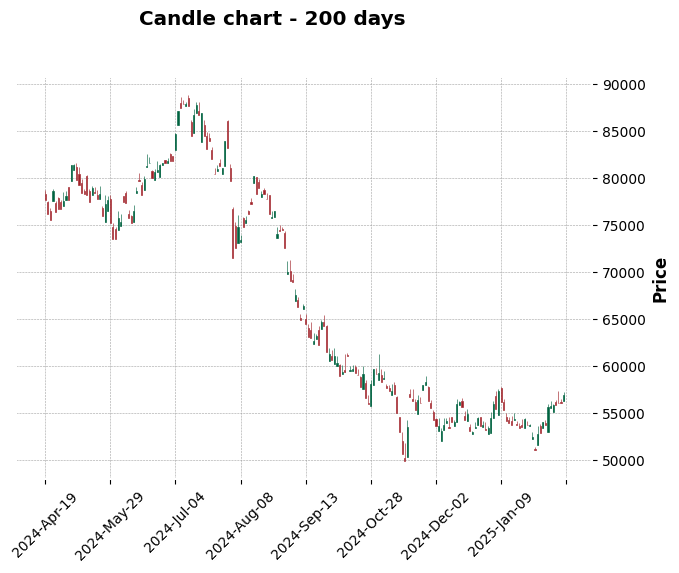

In [10]:
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_candle = ss_pd[['Date', 'Open', 'High', 'Low', 'Close']].copy()
ss_candle.set_index('Date', inplace=True)

mpf.plot(ss_candle[-200:], type='candle', style='charles', title='Candle chart - 200 days')


##### Samsung versus KOSPI cumulative daily return

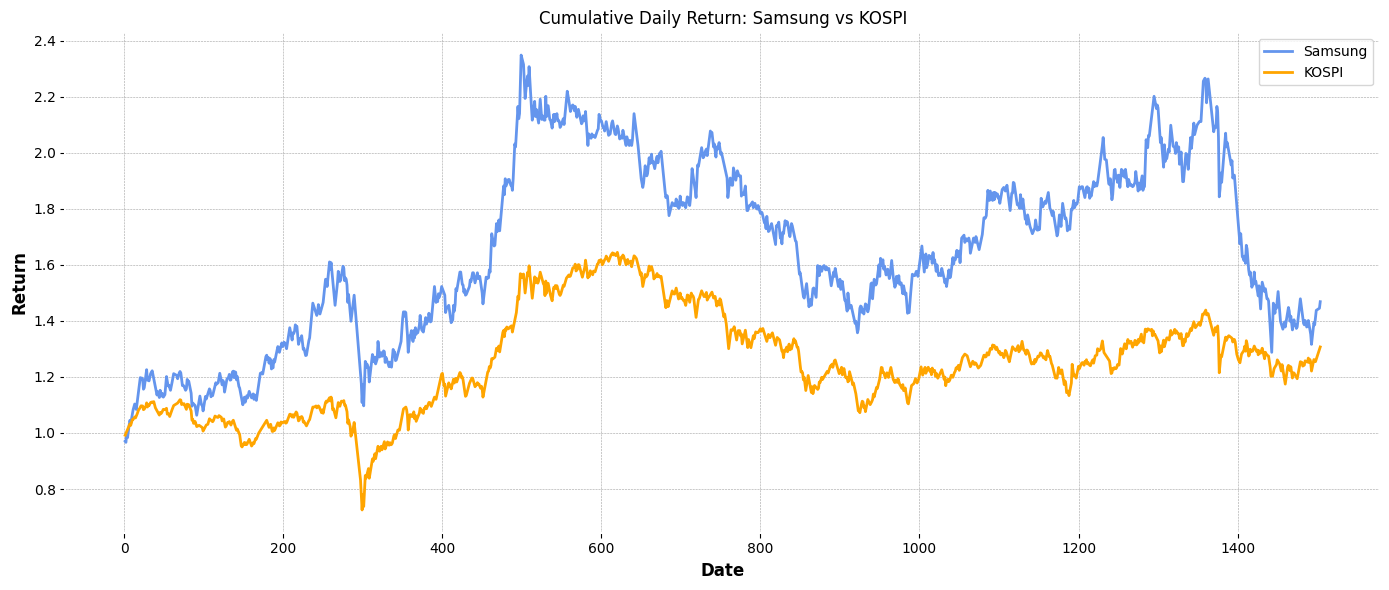

In [11]:
# Calculate daily returns 
ss_pd['Return'] = ss_pd['Close'].pct_change()
kospi_pd['Price'] = pd.to_numeric(kospi_pd['Price'].str.replace(',', ''), errors='coerce')
kospi_pd['Return'] = kospi_pd['Price'].pct_change()
# Merge two dataframes on Date index
returns = pd.merge(
    ss_pd[['Return']], 
    kospi_pd[['Return']], 
    left_index=True, 
    right_index=True, 
    suffixes=('_Samsung', '_KOSPI')
)
# Calculate the cumulative returns
cumulative_returns = (1 + returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns.index, cumulative_returns['Return_Samsung'], label='Samsung', color='cornflowerblue')
plt.plot(cumulative_returns.index, cumulative_returns['Return_KOSPI'], label='KOSPI', color='orange')
plt.title("Cumulative Daily Return: Samsung vs KOSPI")
plt.ylabel("Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Return Distribution

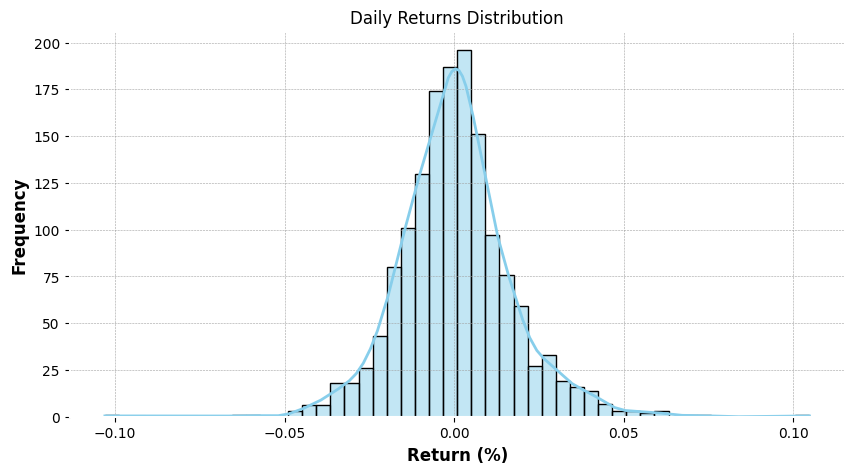

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(ss_pd['Return'].dropna(), bins=50, kde=True, color='skyblue')
plt.title('Daily Returns Distribution')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.show()

##### Trend Analysis

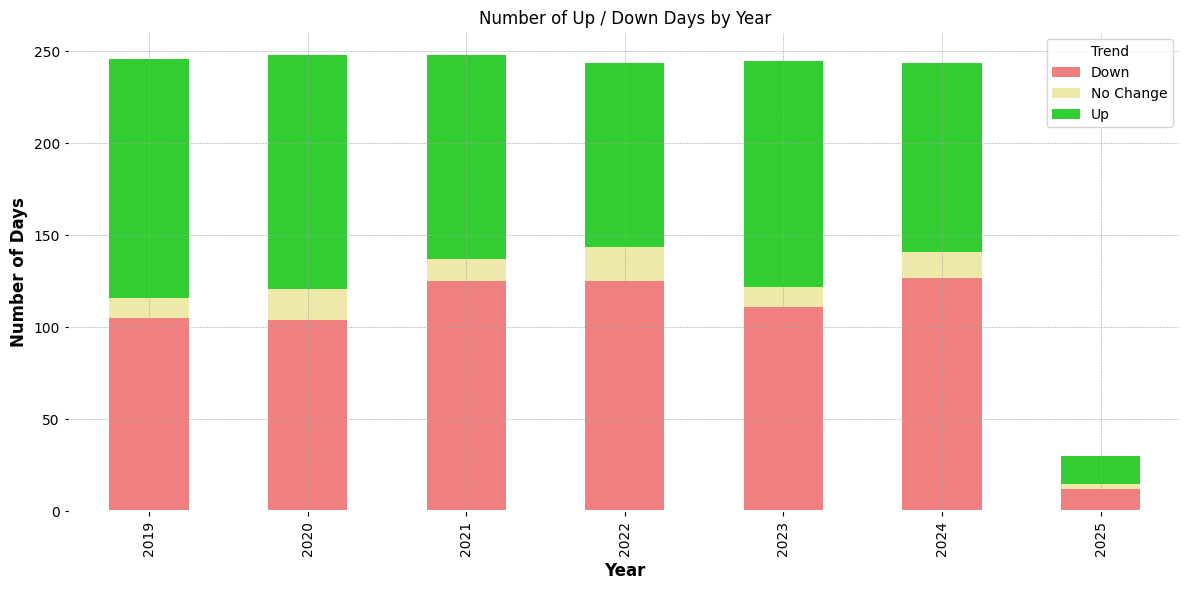

In [13]:
# Label the trend
ss_pd['Trend'] = np.where(ss_pd['Return'] > 0, 'Up', 
                       np.where(ss_pd['Return'] < 0, 'Down', 'No Change'))

ss_pd['Year'] = ss_pd['Date'].dt.year
trend_by_year = ss_pd.groupby(['Year', 'Trend']).size().unstack(fill_value=0)

colors = {
    'Up': 'limegreen',
    'Down': 'lightcoral',
    'No Change': 'palegoldenrod'
}
trend_by_year.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors[col] for col in trend_by_year.columns])
plt.title('Number of Up / Down Days by Year')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.legend(title='Trend')
plt.tight_layout()
plt.show()

##### Stock Price & Trading Volume with SMA (20/50)

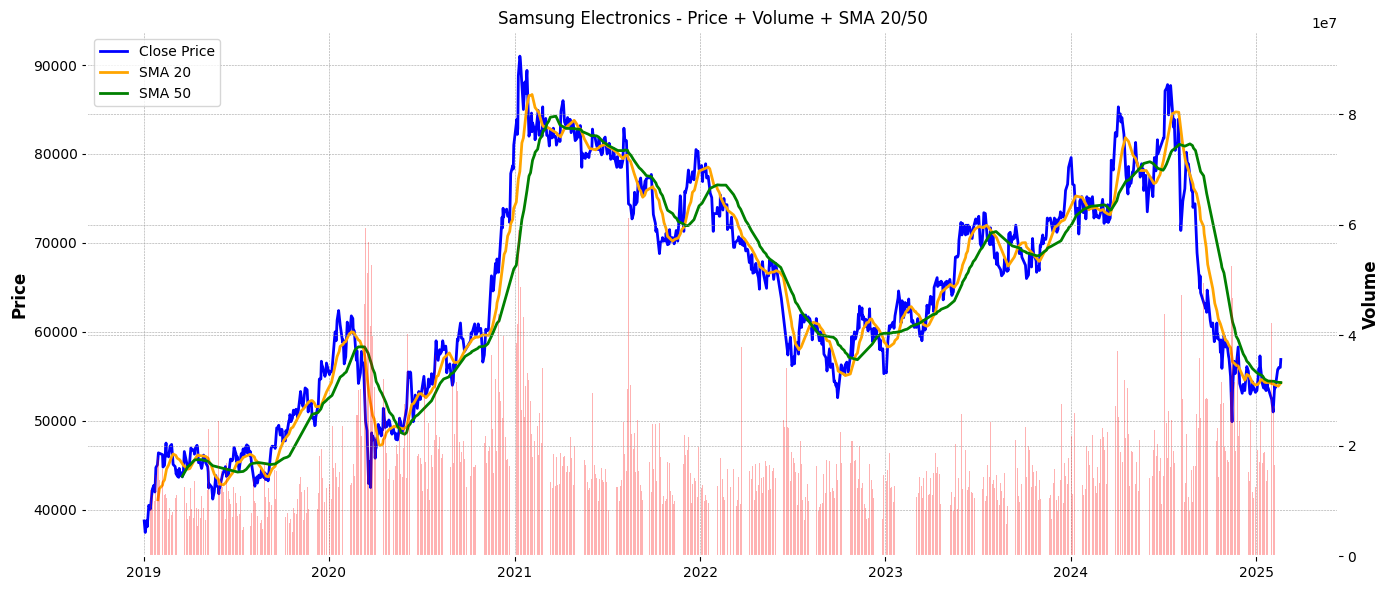

In [14]:
# Đọc dữ liệu
ss_pd = ss_pd.copy()
ss_pd['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Tính SMA 20 và SMA 50
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(df['Date'], df['Close'], label='Close Price', color='blue')
ax1.plot(df['Date'], df['SMA20'], label='SMA 20', color='orange')
ax1.plot(df['Date'], df['SMA50'], label='SMA 50', color='green')
ax1.set_ylabel('Price')
ax1.tick_params(axis='y')

# Vẽ biểu đồ Volume
ax2 = ax1.twinx()
ax2.bar(df['Date'], df['Volume'], color='red', alpha=0.3)
ax2.set_ylabel('Volume')
ax2.tick_params(axis='y')

# Định dạng thời gian
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Samsung Electronics - Price + Volume + SMA 20/50')
ax1.legend(loc='upper left')
fig.tight_layout()
plt.show()


##### Trading Volume with VMA (20/50)

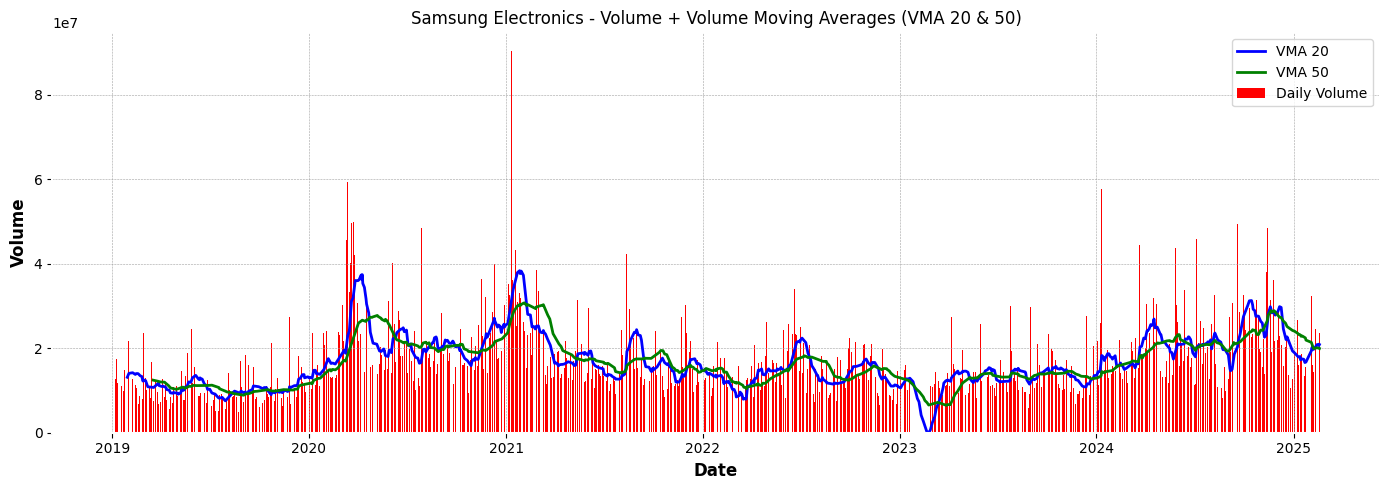

In [15]:
# Đọc dữ liệu
df = ss_pd.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Tính SMA cho Volume (VMA)
df['VMA20'] = df['Volume'].rolling(window=20).mean()
df['VMA50'] = df['Volume'].rolling(window=50).mean()

# Vẽ biểu đồ Volume + VMA
plt.figure(figsize=(14, 5))
plt.bar(df['Date'], df['Volume'], color='red', label='Daily Volume')
plt.plot(df['Date'], df['VMA20'], color='blue', label='VMA 20')
plt.plot(df['Date'], df['VMA50'], color='green', label='VMA 50')

plt.title("Samsung Electronics - Volume + Volume Moving Averages (VMA 20 & 50)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)

# Định dạng trục thời gian
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()



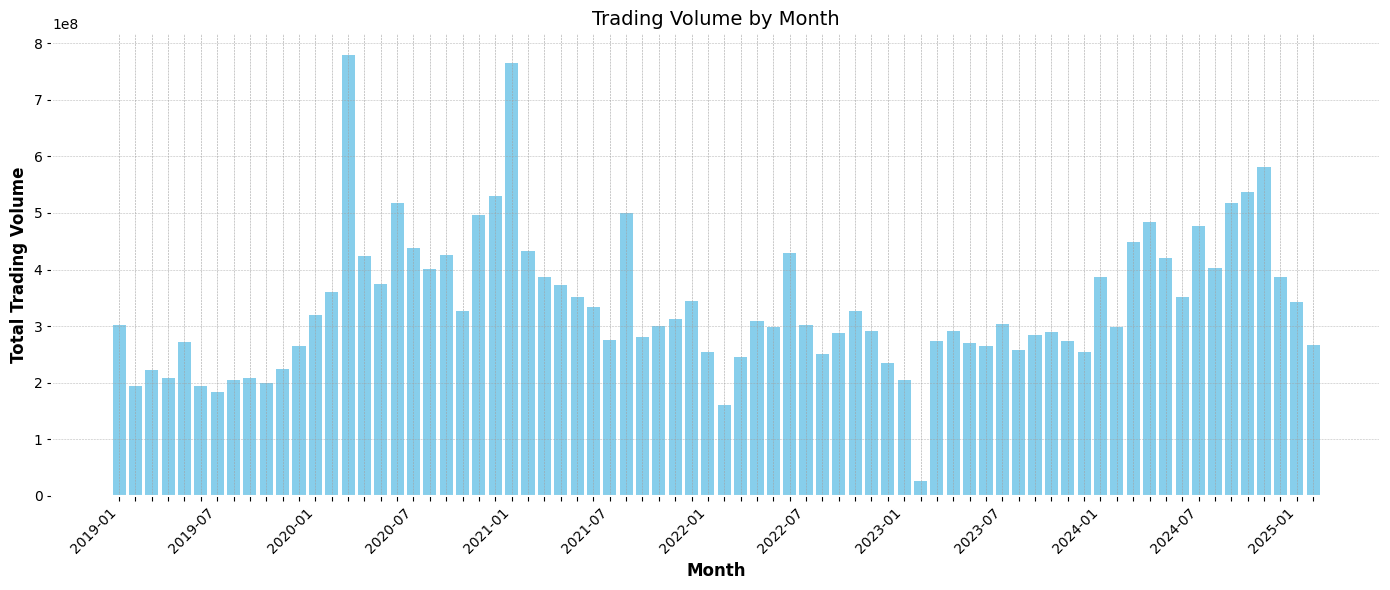

In [16]:
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])

ss_pd['Year'] = ss_pd['Date'].dt.year
ss_pd['Month'] = ss_pd['Date'].dt.month

monthly_volume = ss_pd.groupby(['Year', 'Month'])['Volume'].sum().reset_index()

monthly_volume['Year-Month'] = monthly_volume['Year'].astype(str) + "-" + monthly_volume['Month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 6))
plt.bar(monthly_volume['Year-Month'], monthly_volume['Volume'], color='skyblue')

xticks = monthly_volume['Year-Month']
xtick_labels = [label if i % 6 == 0 else '' for i, label in enumerate(xticks)]
plt.xticks(ticks=range(len(xticks)), labels=xtick_labels, rotation=45, ha='right')

plt.title('Trading Volume by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Trading Volume', fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


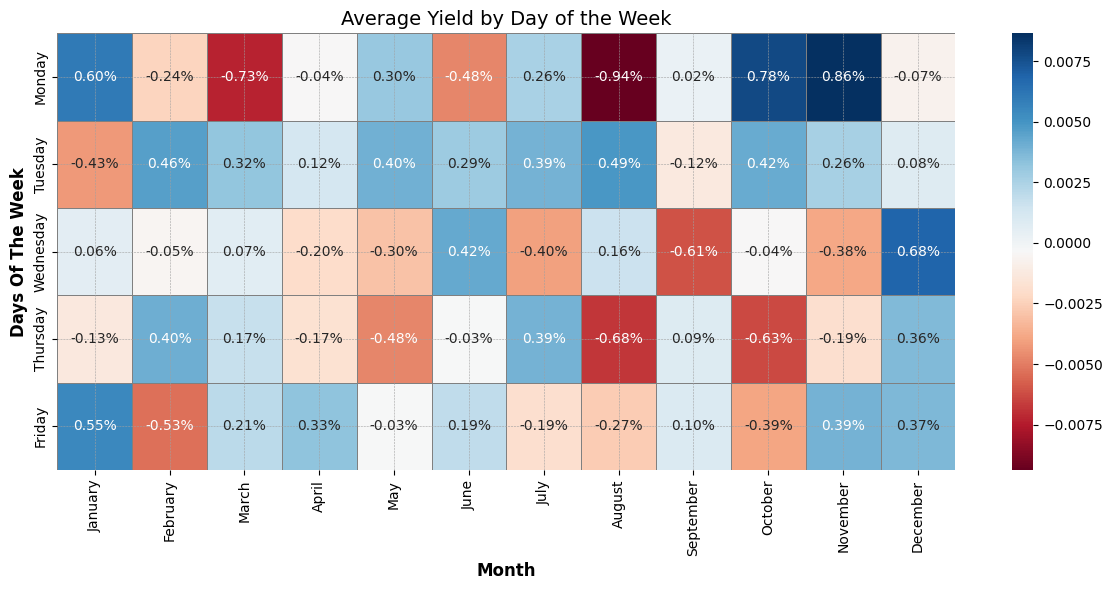

In [17]:

ss_pd = ss_pd.sort_values('Date')


ss_pd['Return'] = ss_pd['Close'].pct_change()


ss_pd['Weekday'] = ss_pd['Date'].dt.day_name()
ss_pd['Month'] = ss_pd['Date'].dt.month_name()


pivot_table = ss_pd.pivot_table(index='Weekday', columns='Month', values='Return', aggfunc='mean')


weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

pivot_table = pivot_table.reindex(index=weekday_order, columns=month_order)


plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='RdBu', annot=True, fmt=".2%", linewidths=0.5, linecolor='gray')
plt.title('Average Yield by Day of the Week', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Days Of The Week')
plt.tight_layout()
plt.show()


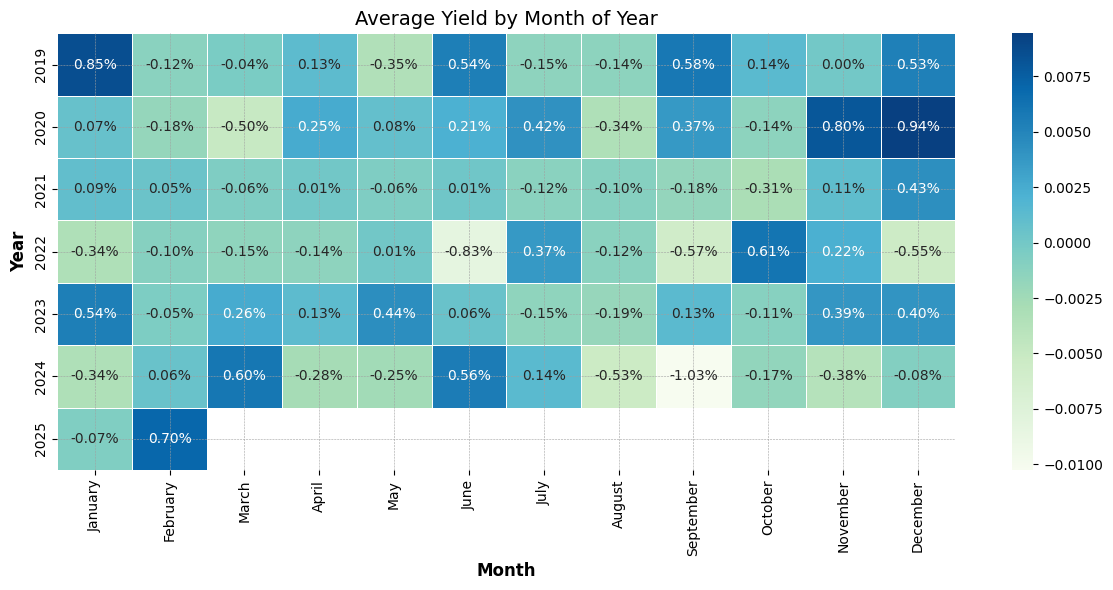

In [18]:
ss_pd = pd.read_csv("Samsung Electronics Stock Historical Price.csv")
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd = ss_pd.sort_values('Date')

ss_pd['Return'] = ss_pd['Close'].pct_change()


ss_pd['Year'] = ss_pd['Date'].dt.year
ss_pd['Month'] = ss_pd['Date'].dt.month_name()

pivot = ss_pd.pivot_table(index='Year', columns='Month', values='Return', aggfunc='mean')

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pivot = pivot[month_order]


plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='GnBu', annot=True, fmt=".2%", linewidths=0.5)
plt.title('Average Yield by Month of Year', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


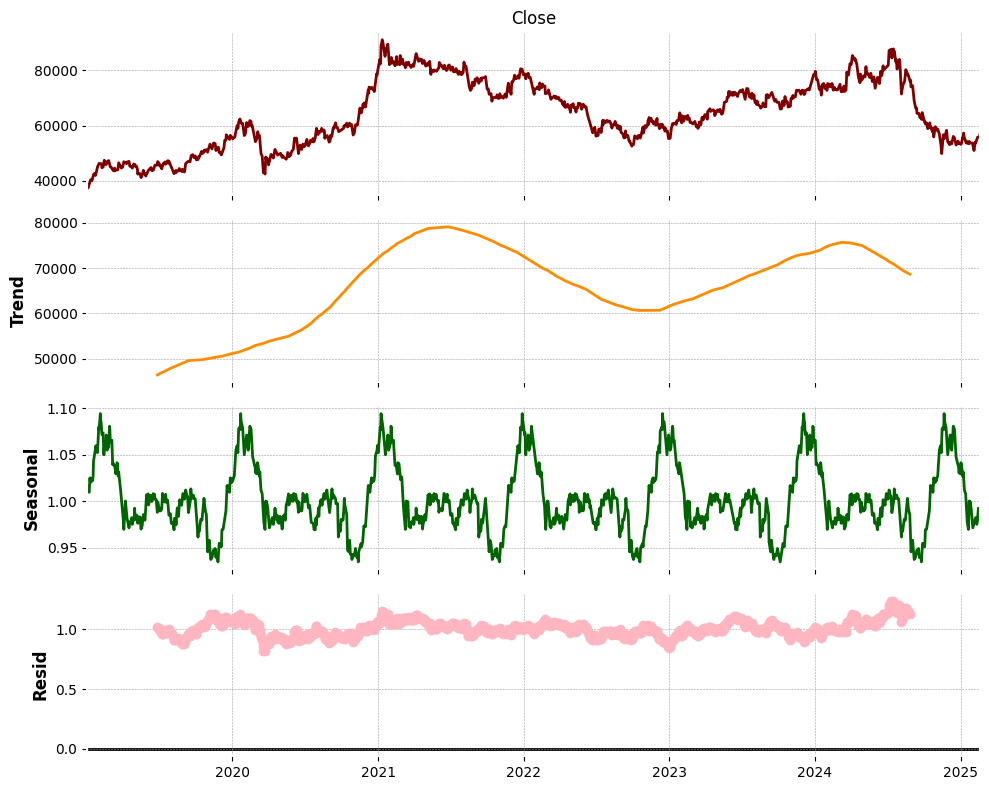

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

file_path = "Samsung Electronics Stock Historical Price.csv"
ss_pd = pd.read_csv(file_path)
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd.sort_values('Date', inplace=True)
ss_pd.set_index('Date', inplace=True)

close_series = ss_pd['Close'].asfreq('B').ffill()

decomposition = seasonal_decompose(close_series, model='multiplicative', period=252)

fig = decomposition.plot()
fig.set_size_inches(10, 8)

axes = fig.axes

axes[0].lines[0].set_color('maroon')      
axes[1].lines[0].set_color('darkorange')       
axes[2].lines[0].set_color('darkgreen')     
axes[3].lines[0].set_color('lightpink')       

plt.tight_layout()
plt.show()



### **2.TECHNICAL ANALYSIS**



Samsung Electronics - Market Sentiment Analysis (as of 2025-02-18)
Current Price: 56,900 KRW
1-Month Momentum: 5.6%
3-Month Momentum: 7.4%
6-Month Momentum: -21.5%

Current Market Sentiment: Greed


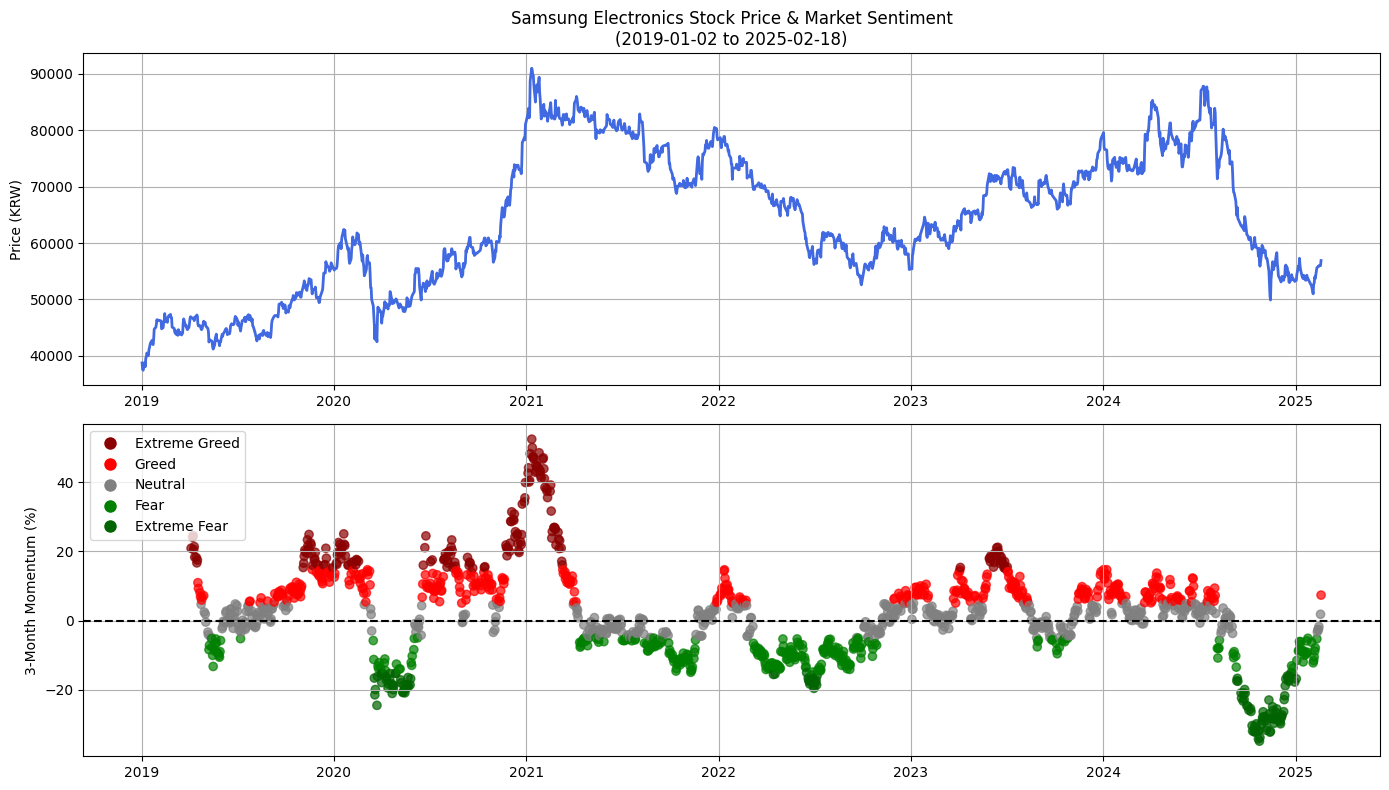

In [16]:


# Calculate momentum indicators
ss_pd['1M_Return'] = ss_pd['Close'].pct_change(21)  # 1-month momentum
ss_pd['3M_Return'] = ss_pd['Close'].pct_change(63)  # 3-month momentum
ss_pd['6M_Return'] = ss_pd['Close'].pct_change(126) # 6-month momentum


# Create sentiment classification
def classify_sentiment(row):
    if row['3M_Return'] > 0.15:
        return 'Extreme Greed'
    elif row['3M_Return'] > 0.05:
        return 'Greed'
    elif row['3M_Return'] < -0.15:
        return 'Extreme Fear'
    elif row['3M_Return'] < -0.05:
        return 'Fear'
    else:
        return 'Neutral'


ss_pd['Sentiment'] = ss_pd.apply(classify_sentiment, axis=1)


# Get latest data
latest = ss_pd.iloc[-1]
latest_date = str(latest['Date'])
latest_close = latest['Close']


# Print analysis
print(f"\nSamsung Electronics - Market Sentiment Analysis (as of {latest_date})")
print("="*60)
print(f"Current Price: {latest_close:,.0f} KRW")
print(f"1-Month Momentum: {latest['1M_Return']*100:.1f}%")
print(f"3-Month Momentum: {latest['3M_Return']*100:.1f}%")
print(f"6-Month Momentum: {latest['6M_Return']*100:.1f}%")
print(f"\nCurrent Market Sentiment: {latest['Sentiment']}")


# Visualization
plt.figure(figsize=(14, 8))

# Ensure 'Date' is datetime and set as index
ss_pd = ss_pd.copy()
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd.set_index('Date', inplace=True)

# Price chart
ax1 = plt.subplot(2, 1, 1)
plt.plot(ss_pd.index, ss_pd['Close'], color='royalblue', linewidth=2)
plt.title(f'Samsung Electronics Stock Price & Market Sentiment\n({ss_pd.index[0].date()} to {ss_pd.index[-1].date()})')
plt.ylabel('Price (KRW)')
plt.grid(True)


# Momentum chart
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
colors = {'Extreme Greed':'darkred', 'Greed':'red', 'Neutral':'gray', 'Fear':'green', 'Extreme Fear':'darkgreen'}
plt.scatter(ss_pd.index, ss_pd['3M_Return']*100, c=ss_pd['Sentiment'].map(colors), alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('3-Month Momentum (%)')
plt.grid(True)


# Formatting
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()


# Add legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Extreme Greed',
                   markerfacecolor='darkred', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Greed',
                   markerfacecolor='red', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Neutral',
                   markerfacecolor='gray', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Fear',
                   markerfacecolor='green', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Extreme Fear',
                   markerfacecolor='darkgreen', markersize=10)]
ax2.legend(handles=legend_elements, loc='upper left')


plt.show()


##### Volume analysis

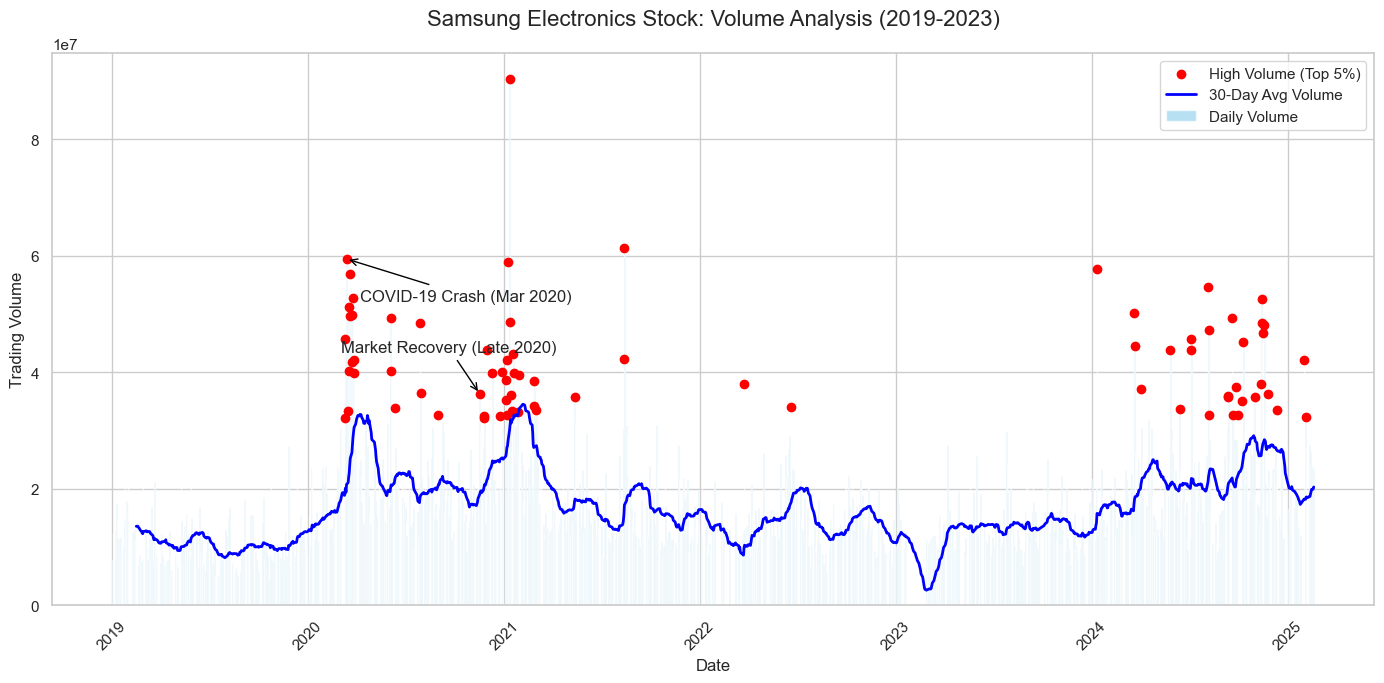

In [18]:
sns.set(style="whitegrid")
# Create the plot
plt.figure(figsize=(14, 7))

# Plot the trading volume
plt.bar(ss_pd.index, ss_pd['Volume'], color='skyblue', alpha=0.6, label='Daily Volume')


# Highlight extreme volume spikes (top 5%)
high_volume_threshold = ss_pd['Volume'].quantile(0.95)
high_volume_days = ss_pd[ss_pd['Volume'] >= high_volume_threshold]
plt.scatter(high_volume_days.index, high_volume_days['Volume'], color='red', label='High Volume (Top 5%)')


# Add moving average for smoother trend (30-day rolling average)
rolling_volume = ss_pd['Volume'].rolling(window=30).mean()
plt.plot(ss_pd.index, rolling_volume, color='blue', linewidth=2, label='30-Day Avg Volume')


# Annotations for notable events
plt.annotate('COVID-19 Crash (Mar 2020)',
             xy=(pd.to_datetime('2020-03-13'), ss_pd.loc['2020-03-13', 'Volume']),
             xytext=(10, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'))


plt.annotate('Market Recovery (Late 2020)',
             xy=(pd.to_datetime('2020-11-16'), ss_pd.loc['2020-11-16', 'Volume']),
             xytext=(-100, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'))


# Labels and title
plt.title('Samsung Electronics Stock: Volume Analysis (2019-2023)', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trading Volume', fontsize=12)
plt.legend()


# Rotate x-axis labels for better readability
plt.xticks(rotation=45)


# Show the plot
plt.tight_layout()
plt.show()


##### MACD & Trade Signal

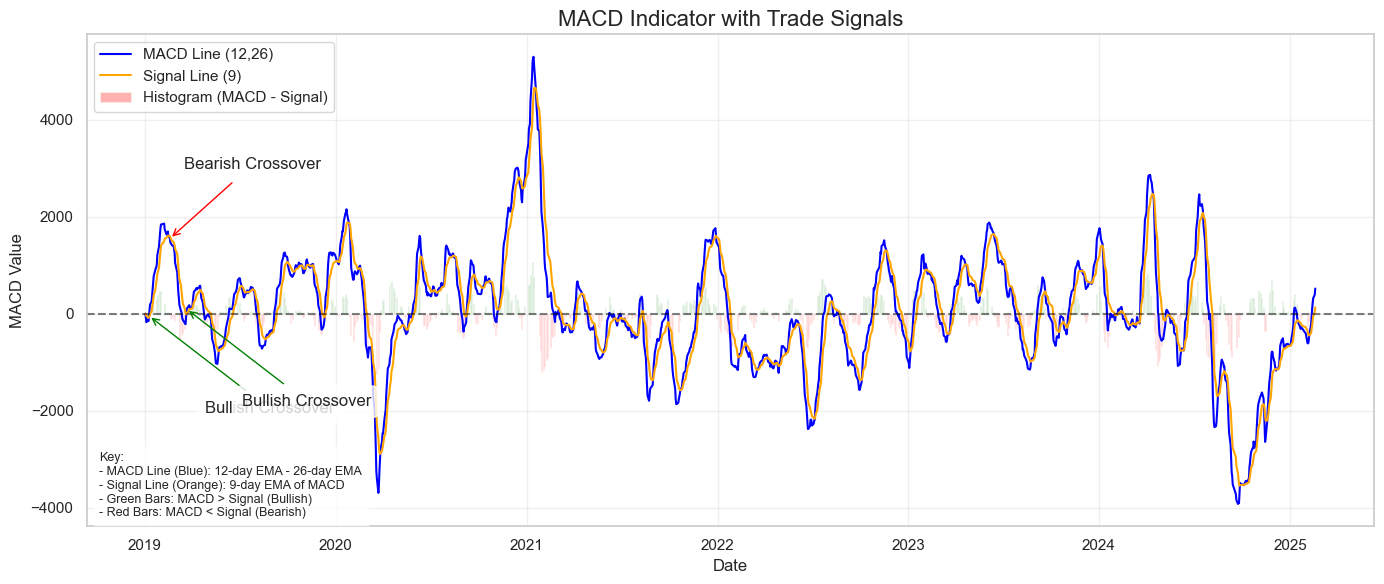

In [19]:
def calculate_macd(ss_pd, fast=12, slow=26, signal=9):
    ss_pd['EMA_Fast'] = ss_pd['Close'].ewm(span=fast, adjust=False).mean()
    ss_pd['EMA_Slow'] = ss_pd['Close'].ewm(span=slow, adjust=False).mean()
    ss_pd['MACD'] = ss_pd['EMA_Fast'] - ss_pd['EMA_Slow']
    ss_pd['Signal_Line'] = ss_pd['MACD'].ewm(span=signal, adjust=False).mean()
    ss_pd['MACD_Histogram'] = ss_pd['MACD'] - ss_pd['Signal_Line']
    return ss_pd


ss_pd = calculate_macd(ss_pd)


# --- Plot MACD with Annotations ---
plt.figure(figsize=(14, 6))


# 1. MACD and Signal Line
plt.plot(ss_pd.index, ss_pd['MACD'], label='MACD Line (12,26)', color='blue', linewidth=1.5)
plt.plot(ss_pd.index, ss_pd['Signal_Line'], label='Signal Line (9)', color='orange', linewidth=1.5)


# 2. Histogram (Green/Red Bars)
plt.bar(ss_pd.index, ss_pd['MACD_Histogram'],
        color=np.where(ss_pd['MACD_Histogram'] > 0, 'green', 'red'),
        alpha=0.3, label='Histogram (MACD - Signal)')


plt.axhline(0, color='black', linestyle='--', alpha=0.5)  # Zero line


# --- Annotations ---
# Find actual crossovers in the data
crossovers = ss_pd[ss_pd['MACD_Histogram'].shift(1) * ss_pd['MACD_Histogram'] < 0]


# Label the first few crossovers (you can adjust this)
for i, date in enumerate(crossovers.index[:3]):  # Show first 3 crossovers
    if ss_pd.loc[date, 'MACD_Histogram'] > 0:  # Bullish crossover
        plt.annotate('Bullish Crossover',
                    xy=(date, ss_pd.loc[date, 'MACD']),
                    xytext=(40, -70), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='green'),
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
    else:  # Bearish crossover
        plt.annotate('Bearish Crossover',
                    xy=(date, ss_pd.loc[date, 'MACD']),
                    xytext=(10, 50), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red'),
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))


# General Explanations
plt.text(
    0.01, 0.02,
    'Key:\n'
    '- MACD Line (Blue): 12-day EMA - 26-day EMA\n'
    '- Signal Line (Orange): 9-day EMA of MACD\n'
    '- Green Bars: MACD > Signal (Bullish)\n'
    '- Red Bars: MACD < Signal (Bearish)',
    transform=plt.gca().transAxes,  # Fixed typo here (transAxex → transAxes)
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.8)
)


plt.title('MACD Indicator with Trade Signals', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('MACD Value', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


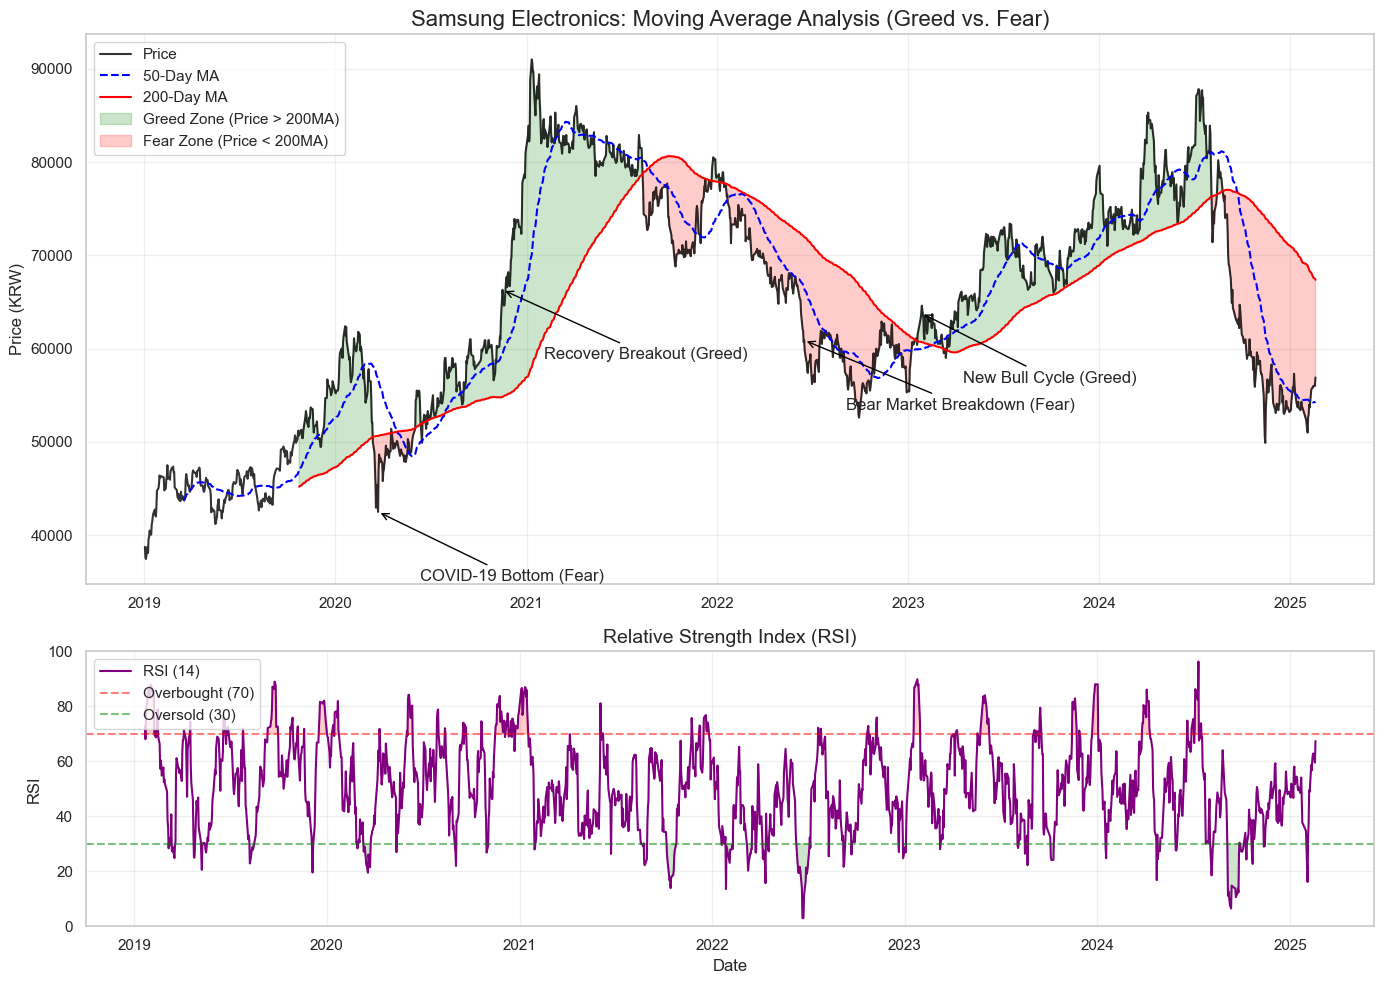

In [20]:
# --- Calculate Moving Averages and Signals (Existing Code) ---
ss_pd['MA_50'] = ss_pd['Close'].rolling(window=50).mean()
ss_pd['MA_200'] = ss_pd['Close'].rolling(window=200).mean()
ss_pd['Signal'] = 0  
ss_pd.loc[ss_pd['Close'] > ss_pd['MA_200'], 'Signal'] = 1  # Greed
ss_pd.loc[ss_pd['Close'] < ss_pd['MA_200'], 'Signal'] = -1  # Fear

# --- Calculate RSI (New Code) ---
def calculate_rsi(ss_pd, window=14):
    delta = ss_pd['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

ss_pd['RSI'] = calculate_rsi(ss_pd)  # Add RSI column

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# 1. Price and Moving Averages (Top Subplot)
ax1.plot(ss_pd.index, ss_pd['Close'], label='Price', color='black', alpha=0.8)
ax1.plot(ss_pd.index, ss_pd['MA_50'], label='50-Day MA', color='blue', linestyle='--')
ax1.plot(ss_pd.index, ss_pd['MA_200'], label='200-Day MA', color='red', linestyle='-')

# Highlight greed/fear zones
ax1.fill_between(ss_pd.index, 
                 ss_pd['Close'].where(ss_pd['Signal'] == 1), 
                 ss_pd['MA_200'].where(ss_pd['Signal'] == 1),
                 color='green', alpha=0.2, label='Greed Zone (Price > 200MA)')
ax1.fill_between(ss_pd.index, 
                 ss_pd['Close'].where(ss_pd['Signal'] == -1), 
                 ss_pd['MA_200'].where(ss_pd['Signal'] == -1),
                 color='red', alpha=0.2, label='Fear Zone (Price < 200MA)')

# Annotate events (adjusted xytext for spacing)
events = {
    '2020-03-23': 'COVID-19 Bottom (Fear)',
    '2020-11-16': 'Recovery Breakout (Greed)',
    '2022-06-16': 'Bear Market Breakdown (Fear)',
    '2023-01-26': 'New Bull Cycle (Greed)'
}
for date, label in events.items():
    if pd.to_datetime(date) in ss_pd.index:
        price = ss_pd.loc[pd.to_datetime(date), 'Close']
        ax1.annotate(label, xy=(pd.to_datetime(date), price),
                     xytext=(30, -50), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->', color='black'))

ax1.set_title('Samsung Electronics: Moving Average Analysis (Greed vs. Fear)', fontsize=16)
ax1.set_ylabel('Price (KRW)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. RSI Chart (Bottom Subplot)
ax2.plot(ss_pd.index, ss_pd['RSI'], label='RSI (14)', color='purple', linewidth=1.5)
ax2.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax2.axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
ax2.fill_between(ss_pd.index, 70, ss_pd['RSI'].where(ss_pd['RSI'] >= 70), 
                 color='red', alpha=0.2)
ax2.fill_between(ss_pd.index, 30, ss_pd['RSI'].where(ss_pd['RSI'] <= 30), 
                 color='green', alpha=0.2)

ax2.set_title('Relative Strength Index (RSI)', fontsize=14)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('RSI', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)  # RSI ranges from 0 to 100

plt.tight_layout()
plt.show()
